In [1]:
import sys
import numpy as np
import pandas as pd 
import tensorflow_probability as tfp
import tensorflow
import tensorflow.compat.v2 as tf
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR)
sys.path.append("/home/mindy/Documents/projects/creditCardFraud/scripts/")

In [2]:
tfk = tf.keras
tfkl=tf.keras.layers
tfpl= tfp.layers         # layers for tensor flow probability 
tfd = tfp.distributions # distribution layer 

In [3]:
from util import *
from NN_util import *
%load_ext autoreload
%autoreload 2

In [4]:
# make sure GPU is running 
tf.test.gpu_device_name()
# set max limit to 7.5 G /8 total available 
set_gpu_limit(7.5)

## Import training and dev data and convert to numpy array for NN 

In [5]:
train = pd.read_csv("../processedData/TrainingData_normal.csv")
dev = pd.read_csv("../processedData/DevData_normal.csv")

### converting into tf data set to allow simple efficient data pipelines. 
* In autoencoder, you are predicting the original input x 
* shuffle and train data in batches with 1000 epochs 

In [6]:
buffer_size = 10000
batch_size = 256
sizes = [20,10]
epochs = 500
input_size = train.shape[1]
encoded_size = 5

In [7]:
train_data, dev_data = make_tensor_dataset([train,dev],buffer_size,batch_size)

### set up checkpoint and other settings 

In [8]:
checkpoint = tfk.callbacks.ModelCheckpoint("../savedModels/VariationalEncoderModel.h5",verbose=1,save_best_only=True)
earlystop = tfk.callbacks.EarlyStopping(monitor="val_loss", mode="min", min_delta=0.005, patience=20, verbose=1, restore_best_weights=True)

### For variational autoencoder we need to maximize ELBO (evidence lower bound objective):

$$ELBO(x)= \int dzq(z|x)logp(x|z) + \int dzq(z|x)log\frac{q(z|x)}{p(z)} $$

* p(z): the prior on the latent representation z (last layer of encoder) 
* q(z|x_input): the encoder (how likely is z given x_input)
* p(x_hat|z): the decoder (how likely is x_hat given z) 
* $\int dzq(z|x)logp(x|z)$: reconstructin term. (how likely for us to get output_x given input_x and encode to z then decode to x_output) 
* $\int dzq(z|x)log\frac{q(z|x)}{p(z)} $: KL divergence. How similar are the encoder distribution and the prior distribution. 

### Prior distribution for z: 

* Since this is latent representation (noise has been removed), it is okay to assume it is isotropic gaussian 

In [9]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

## encoder model for autoencoder:
* encoder: 3 layers:
  * 3 dense layers 
  * 3 dimensional multivariable non zero covariance normal distribution

## decoder model for autoencoder:
* decoder: 3 layers:
   * 3 dense layers
   * independent normal distributions as output 

### Add encoders together 


In [10]:
VAE, encoder, decoder = make_autoencoder(sizes,input_size, ifvae=True,encoded_size=encoded_size, prior = prior)

In [11]:
VAE.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
sequential (Sequential)      (None, 10)                830       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 5), (None, 5))    0         
_________________________________________________________________
decoder (Sequential)         (None, 30)                1540      
Total params: 2,590
Trainable params: 2,590
Non-trainable params: 0
_________________________________________________________________


### define reconstruction loss

In [12]:
negloglik = lambda x_input, x_output: -x_output.log_prob(x_input)

### compile the model and train model

In [13]:
VAE.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=negloglik)

In [17]:
# history = VAE.fit(train_data,epochs=epochs,shuffle=True,
#                           verbose=1,validation_data=dev_data,
#                           callbacks=[checkpoint,earlystop])

In [18]:
# plot_loss(history)

In [28]:
VAE.load_weights("../savedModels/VariationalEncoderModel_3.h5")

### create monte carlo to generate output log prob score for anomaly prediction

In [20]:
test = pd.read_csv("../processedData/hold_outset_moreFraud.csv")

In [21]:
test_tf_data, label = test.drop("Class",axis=1), test["Class"]

In [29]:
for i in range(5):
    x_log_prob,y_label = reconstruction_log_prob_sampled(test_tf_data,label,1000,encoder,decoder,sampling_size=100)
    results = model_results(y_label,-x_log_prob)
    print("anomaly output")
    print(results[results.label==1].anomaly_prob.describe())
    print("normal output")
    print(results[results.label==0].anomaly_prob.describe())

anomaly output
count      7.000000
mean     103.464546
std       24.630816
min       57.862984
25%       92.274647
50%      117.690964
75%      118.704002
max      126.740547
Name: anomaly_prob, dtype: float64
normal output
count    993.000000
mean      26.351913
std       15.537874
min      -26.477896
25%       16.701319
50%       27.852619
75%       36.152180
max       71.133080
Name: anomaly_prob, dtype: float64
anomaly output
count      5.000000
mean     119.586380
std        5.117850
min      115.817719
25%      115.843643
50%      118.434669
75%      119.575813
max      128.260025
Name: anomaly_prob, dtype: float64
normal output
count    995.000000
mean      26.470171
std       15.583405
min      -28.545010
25%       17.549416
50%       28.058064
75%       35.977886
max       97.070091
Name: anomaly_prob, dtype: float64
anomaly output
count      9.000000
mean     114.169403
std       13.221819
min       92.379112
25%      105.235352
50%      120.118439
75%      125.928810
max    

### This gives a rough idea on where the threshold should be set 

In [30]:
x_log_prob = reconstruction_log_prob(test_tf_data.values,1000,encoder,decoder)

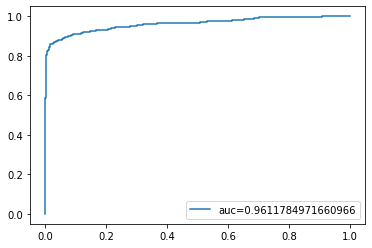

In [31]:
plot_roc(label,-x_log_prob)

### Choose a threshold that gives a good overall class1 recall 

In [47]:
output = model_results(label,-x_log_prob,75,ifprint=True)

[[56747   111]
 [  110   382]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56858
           1       0.77      0.78      0.78       492

    accuracy                           1.00     57350
   macro avg       0.89      0.89      0.89     57350
weighted avg       1.00      1.00      1.00     57350

